## Generate data with transient dynamic observations where experiment is concluded at steady state observation

In [1]:
from data.budworm import budworm_ode
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
def f_true(x):
    return -1*x / (1+x**2)

def g_true(x,k,r):
    return -(r/k)*x**3 + r*x**2 -(r/k)*x +r 
def dg_true(x,k,r):
    return -2*(r/k)*x**2 + 2*r*x - (r/k)

def budworm_steady_states(k,r):
    """
    for a given k and r return real x such that 
    g(x,k:r) = x

    find roots of polynomial 
    p(x) = g(x,k;r)-x = -r/k x^3 + rx^2 -(r/k+1)x+r
    """
    a = -r/k
    b = r
    c=-(r/k + 1)
    d = r
    roots = np.roots([a,b,c,d])

    return sorted([r.real for r in roots if np.isreal(r)])

def converging_steady_state(steady_states,x0):
    if len(steady_states)==3:
        if x0 < steady_states[1]:
            return steady_states[0]
        return steady_states[-1]
    return steady_states[0]

def get_t_star(x0,xs,r,k,eps=1e-3):
    lam = f_true(xs)*(1-dg_true(xs,k,r))
    return 1 / np.abs(lam) * np.log(np.abs(x0-xs)/eps)

## control function

In [ ]:
from sympy import symbols, Eq, solve, simplify

r, k = symbols('r k', positive=True)
a = r/k
b = -r
c = (k+r)/k
d = -r
p = (3*a*c-b**2) / (3*a**2)
q = (2*b**3 - 9*a*b*c+27*a**2*d) / (27*a**3)

D = - (4*p**3 + 27*q**2)
D = simplify(D)


D_fixed = D.subs(r, 0.56)
r1, r2 = solve(Eq(D_fixed, 0), k)
print(r1,r2)

k1 = r1-1.1
k2 = r2+1.1

def smooth_k(t):
    A = (k2-k1)/2
    return A*np.sin(t-np.pi/2)+A + k1

6.44569072482332 9.93441120446710


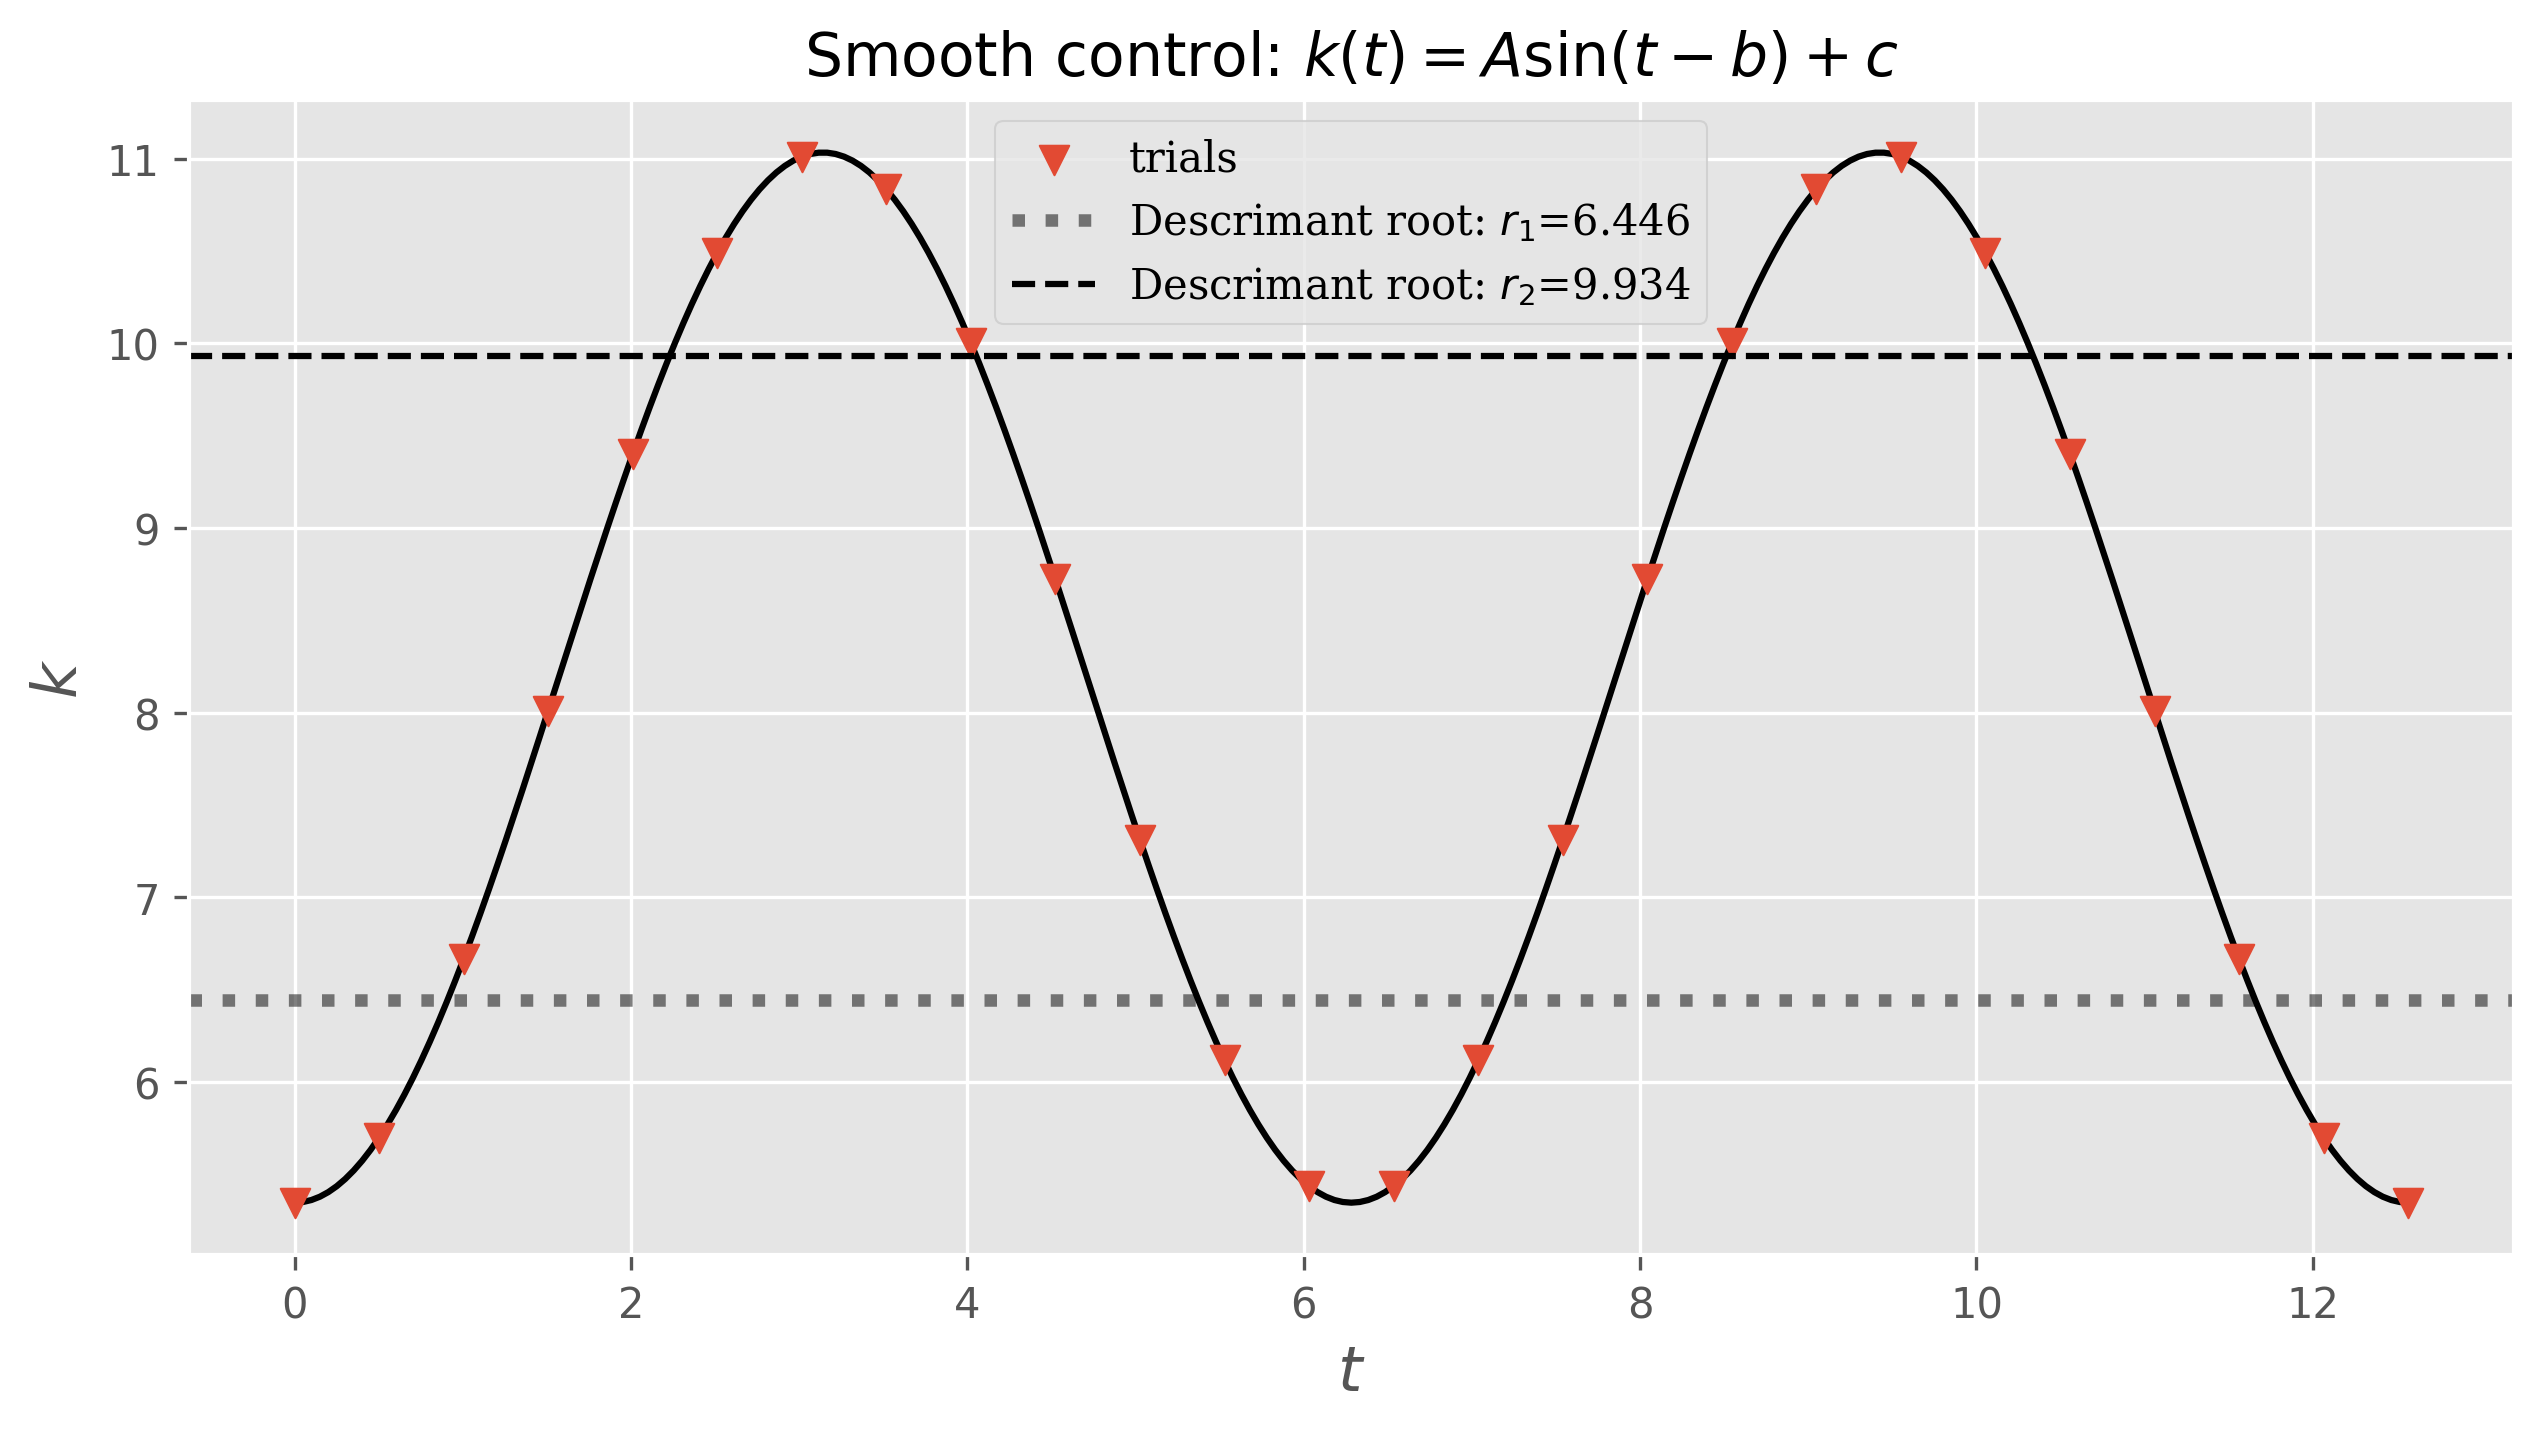

In [37]:
t_span = np.linspace(0,4*np.pi,251)
t_trials = t_span[::10]
k_true = smooth_k(t_span)
k_trials = smooth_k(t_trials)


fig, ax = plt.subplots(1,1,figsize=(10,5),dpi=300)
t_span = np.linspace(0,4*np.pi,251)
sample_rate = 10
ax.plot(t_span, k_true,c='black',zorder=1)
ax.scatter(
    t_span[::sample_rate],
    k_trials,
    label='trials',
    marker='v',
    s=50,
    zorder=2
)
ax.grid(True)
ax.axhline(r1,linestyle=':',c='black', alpha=0.5,label=rf"Descrimant root: $r_1$={r1:.3f}",lw=3)
ax.axhline(r2, linestyle='--',c='black', label=rf"Descrimant root: $r_2$={r2:.3f}")
ax.set_ylabel(r"$k$", size=15)
ax.set_xlabel(r"$t$",size=15)
ax.set_title(r"Smooth control: $k(t) = A\sin(t-b)+c$")
ax.legend(prop={'family':'serif'})
plt.savefig("budworm_smooth_control.pdf")
plt.show()

In [3]:
# t_end =50
r=0.56
k=7
x0 = 2-0.001
x0=1


In [4]:
xs = budworm_steady_states(k,r)
xs_star = converging_steady_state(xs,x0)
t_star = get_t_star(x0,xs_star,r,k,)

In [5]:
buffer = 0.2
t_end = t_star + buffer
dt = 0.2
t_eval = np.arange(0,t_end,dt)


In [6]:
sol = solve_ivp(budworm_ode,t_span=[0,t_end],y0=np.array([x0]),t_eval=t_eval,args=(r,k,))

In [7]:
t_star_idx = np.argmin(np.abs(sol.t-t_star))

sol.y[0,t_star_idx:t_star_idx+4] - xs_star

array([0.00040863, 0.00039656])

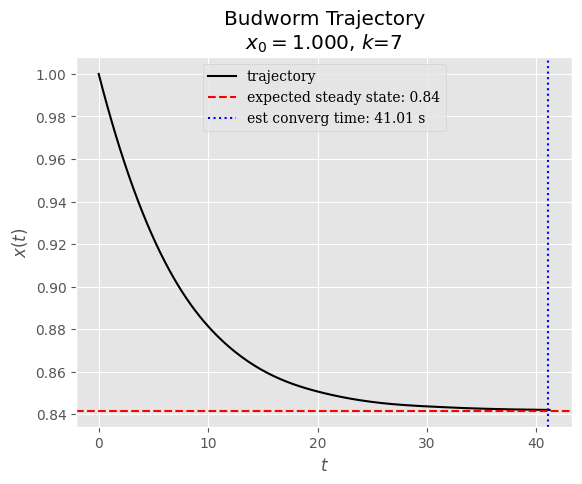

In [8]:
plt.plot(sol.t, sol.y.squeeze(),c='black', label="trajectory")
plt.xlabel(r"$t$")
plt.ylabel(r"$x(t)$")

# if len(xs) > 1:
#     for idx, xs_i in enumerate(xs):
#         if idx ==0:
#             plt.axhline(xs_i,linestyle='--',c='black',alpha=0.5,label='steady state')
#         plt.axhline(xs_i,linestyle='--',c='black',alpha=0.5,)

plt.axhline(xs_star,linestyle='--',c='red',label=f'expected steady state: {xs_star:.2f}')
plt.axvline(t_star,linestyle=':',c='blue' ,label=f'est converg time: {t_star:.2f} s',)
plt.title("Budworm Trajectory\n" +rf"$x_0 =${x0:.3f}, $k$={k}")
plt.legend(prop={'family':'serif'})
plt.show()

In [58]:
x0 = 1
ks = k_trials
dt = 0.2
r=0.56
eps=1e-3
buffer = 1e-1

x_curr = x0

x_vals = []
t_vals = []
x_stars = []
t_stars = []
for k in ks:
    # determine steady states
    xs = budworm_steady_states(k,r)
    x_star = converging_steady_state(xs,x_curr)
    t_star = np.abs(get_t_star(x_curr,x_star,r,k,eps=eps))

    t_end = t_star + buffer
    t_span = [0,t_end]
    t_eval = np.arange(0,t_end, dt)

    

    sol = solve_ivp(
        fun=budworm_ode,
        t_span=t_span,
        y0=np.array([x_curr]),
        t_eval=t_eval,
        args=(r,k)
    )
    out = sol.y
    x_curr = sol.y[0,-1]

    x_vals.append(sol.y[0,:])
    t_vals.append(sol.t)
    x_stars.append(x_star)
    t_stars.append(t_star)



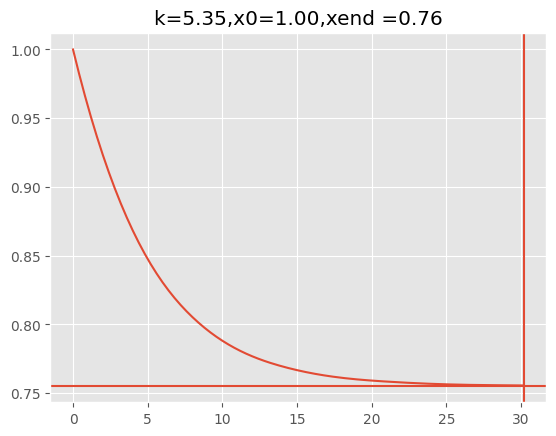

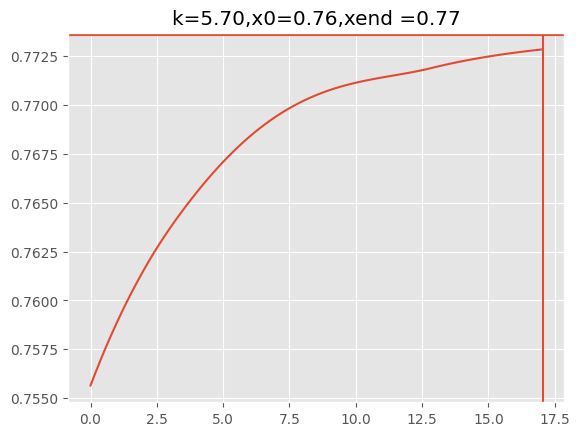

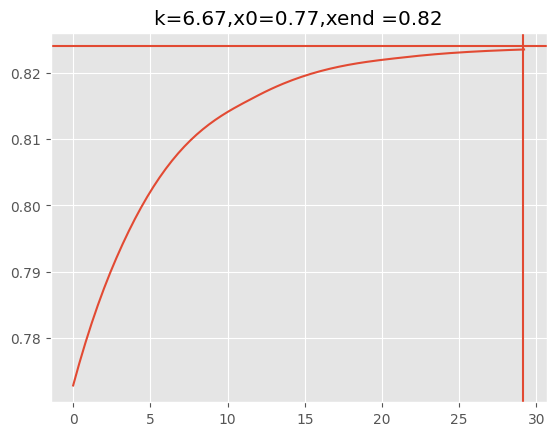

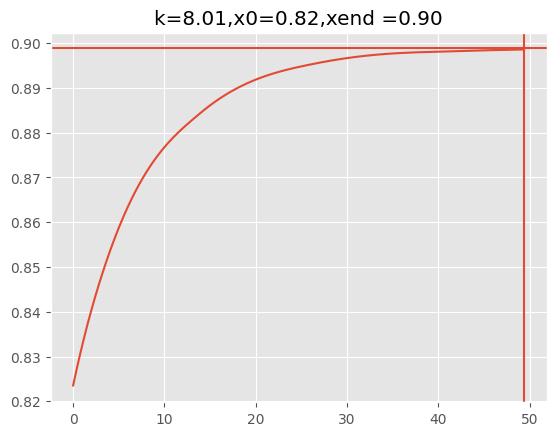

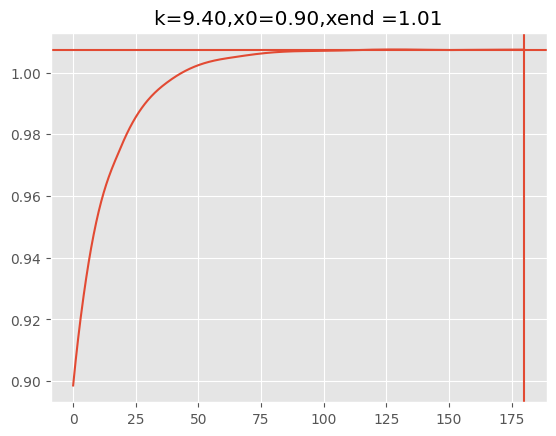

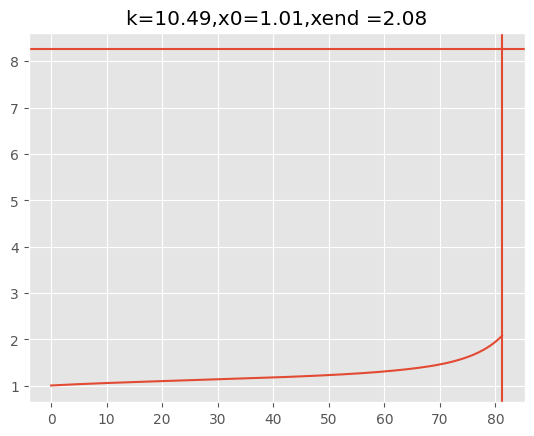

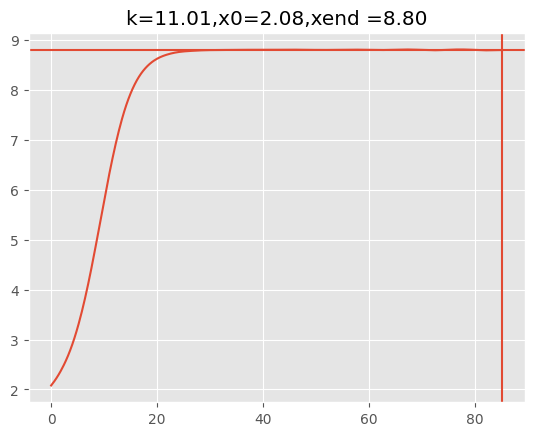

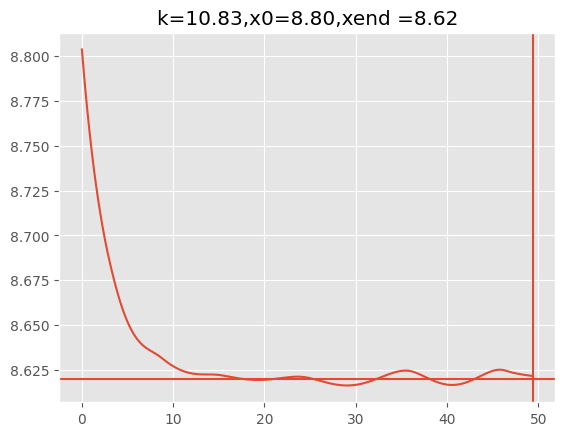

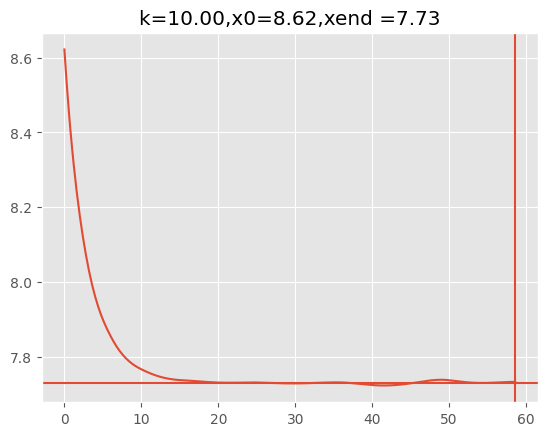

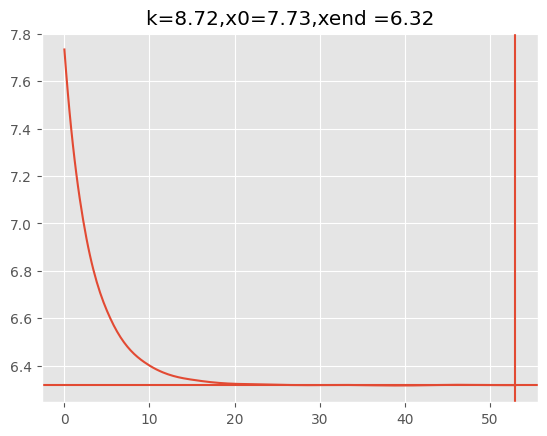

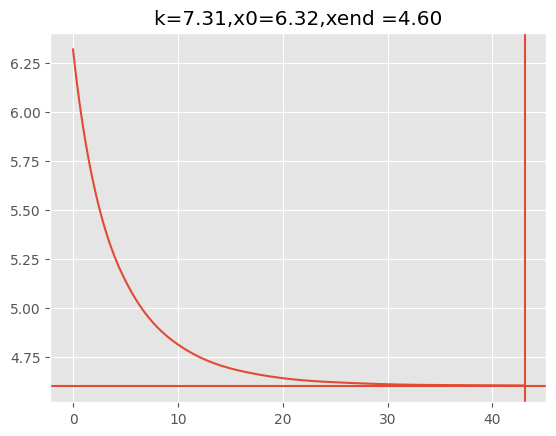

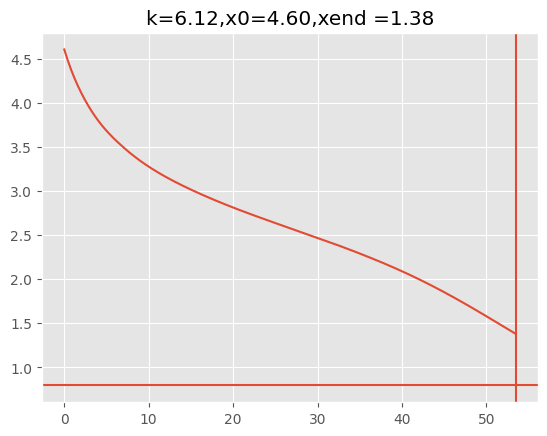

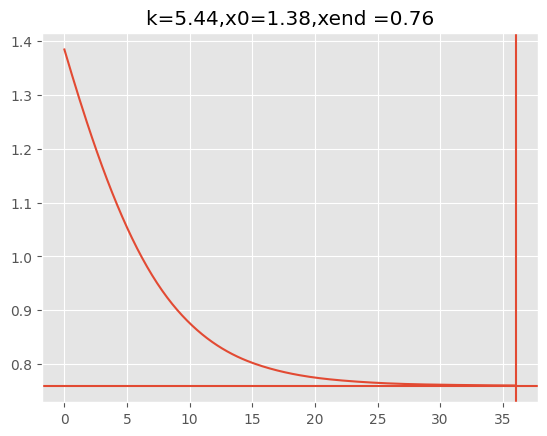

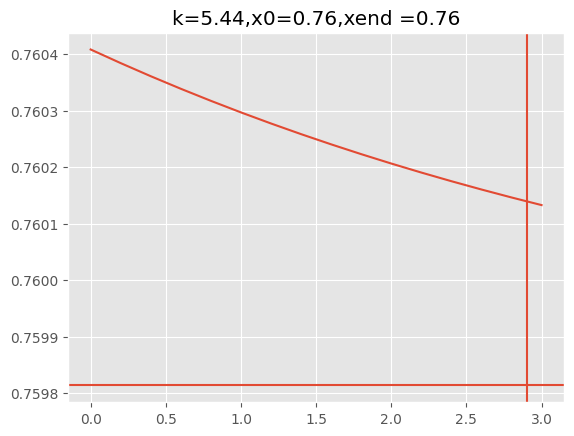

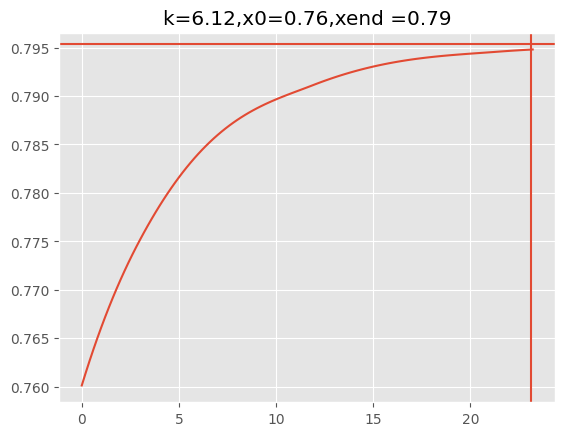

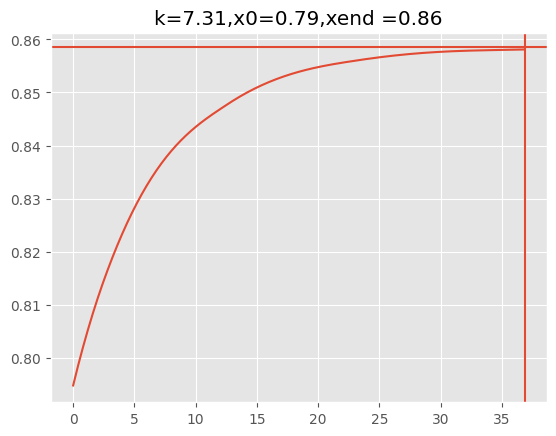

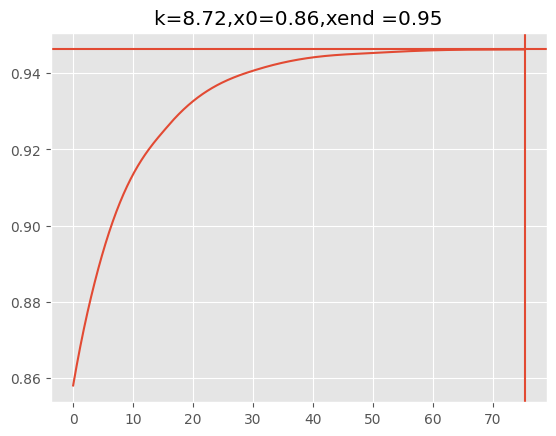

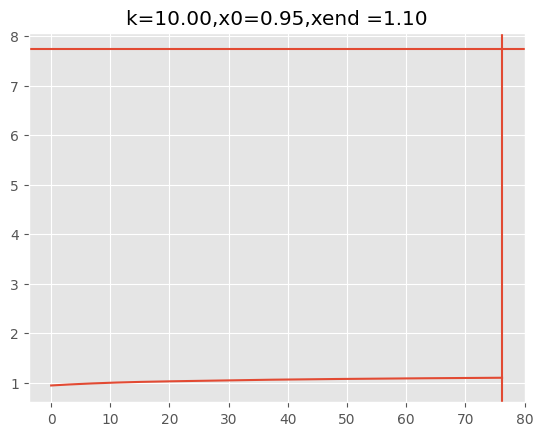

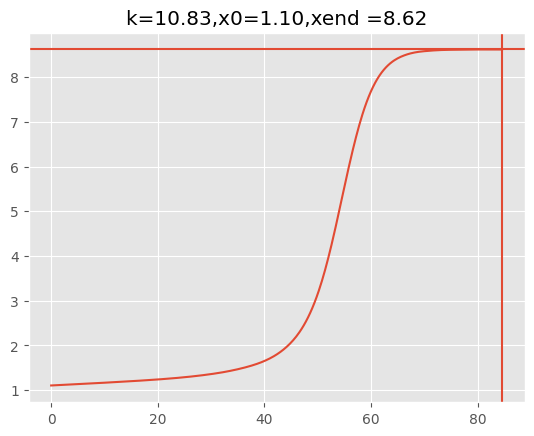

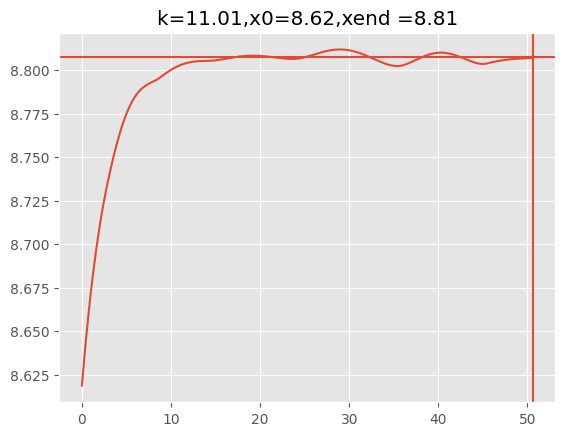

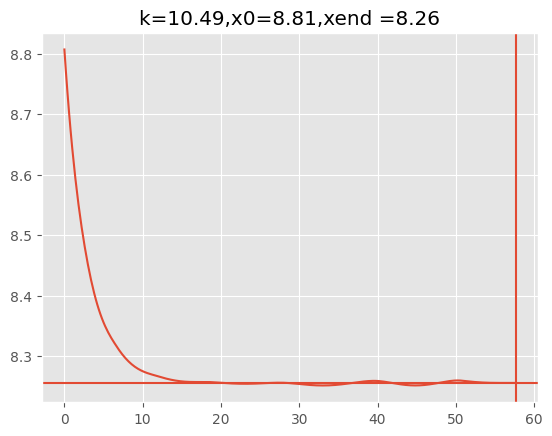

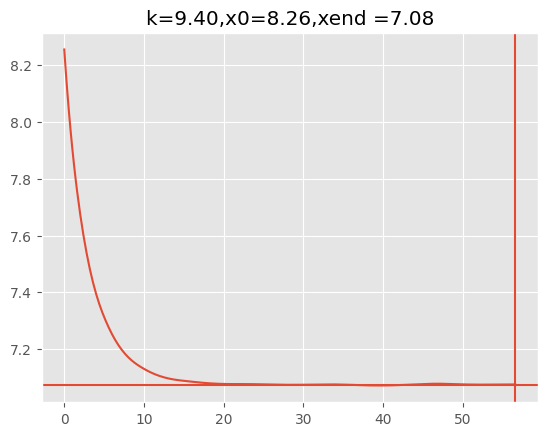

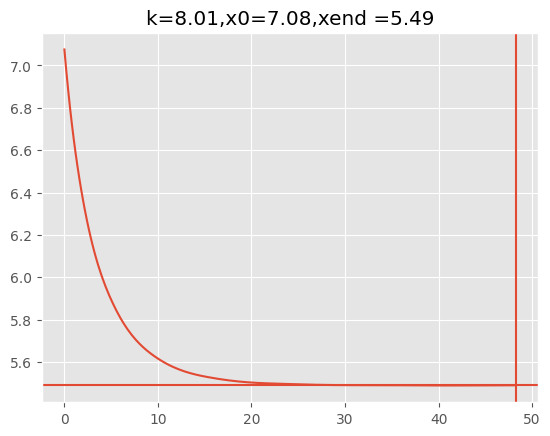

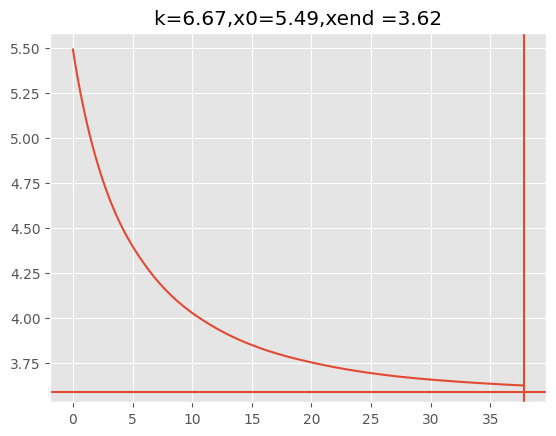

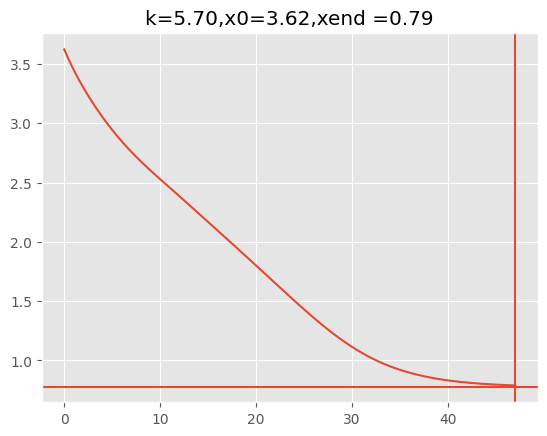

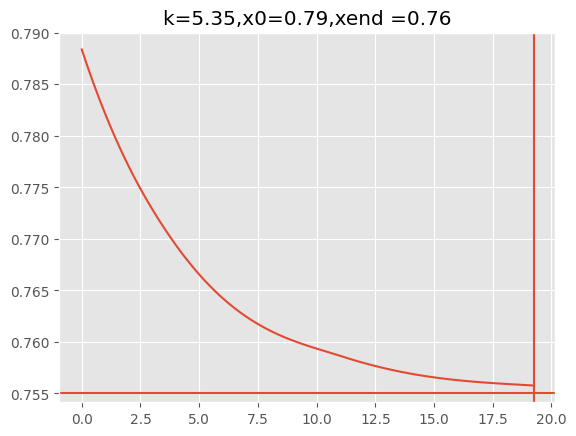

In [62]:
for x,t,xs,ts,ki in zip(x_vals,t_vals,x_stars,t_stars,ks):
    plt.plot(t,x)
    plt.axhline(xs)
    plt.axvline(ts)
    plt.title(f"k={ki:.2f},x0={x[0]:.2f},xend ={x[-1]:.2f}")
    plt.show()

In [48]:
x_star

0.7550866705971837